In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer




ModuleNotFoundError: No module named 'tensorflow'

## Data Collection

In [4]:
df = pd.read_csv('data/train.tsv', sep='\t')
df.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [9]:
df.shape

(156060, 4)

In [5]:
df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [8]:
df.drop_duplicates(subset=['SentenceId'], keep='first').shape


(8529, 4)

In [11]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:>

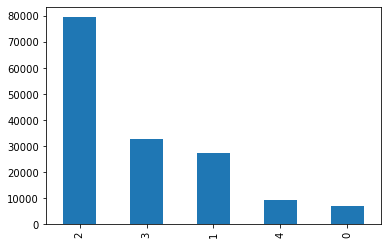

In [10]:
df['Sentiment'].value_counts().plot(kind='bar')

## Data Preprocessing

In [12]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [15]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length=seq_len, 
                   truncation=True,
                   padding='max_length', 
                   add_special_tokens=True,
                   return_tensors='np')


In [16]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
tokens

{'input_ids': array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [18]:
with open('data/movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
    
with open('data/movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [19]:
del tokens

In [20]:
# first extract sentiment column
arr = df['Sentiment'].values

In [21]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [22]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [23]:
with open('data/movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## Dataset Building

In [26]:
with open('data/movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
    
with open('data/movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
    
with open('data/movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

NameError: name 'tf' is not defined